# Regional Effects (unknown black-box function)

This tutorial use the same dataset with the previous [tutorial](./03_regional_effects_synthetic_f/), but instead of explaining the known (synthetic) predictive function, we fit a neural network on the data and explain the neural network. This is a more realistic scenario, since in real-world applications we do not know the underlying function and we only have access to the data. We advise the reader to first read the previous tutorial.

In [1]:
import numpy as np
import effector
import keras
import tensorflow as tf

np.random.seed(12345)
tf.random.set_seed(12345)

2025-02-26 11:26:23.961349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Simulation example

### Data Generating Distribution

We will generate $N=500$ examples with $D=3$ features, which are in the uncorrelated setting all uniformly distributed as follows:

<center>

| Feature | Description                                | Distribution                 |
|---------|--------------------------------------------|------------------------------|
| $x_1$   | Uniformly distributed between $-1$ and $1$ | $x_1 \sim \mathcal{U}(-1,1)$ |
| $x_2$   | Uniformly distributed between $-1$ and $1$ | $x_2 \sim \mathcal{U}(-1,1)$ |
| $x_3$   | Uniformly distributed between $-1$ and $1$ | $x_3 \sim \mathcal{U}(-1,1)$ |

</center>

For the correlated setting we keep the distributional assumptions for $x_2$ and $x_3$ but define $x_1$ such that it is highly correlated with $x_3$ by: $x_1 = x_3 + \delta$ with $\delta \sim \mathcal{N}(0,0.0625)$.

In [2]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x3 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x1 = x3 + np.random.normal(loc = np.zeros_like(x3), scale = 0.25)
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 1000
X_uncor_train = generate_dataset_uncorrelated(N)
X_uncor_test = generate_dataset_uncorrelated(10000)
X_cor_train = generate_dataset_correlated(N)
X_cor_test = generate_dataset_correlated(10000)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$ 
 
On a global level, there is a high heterogeneity for the features $x_1$ and $x_3$ due to their interaction with each other. However, this heterogeneity vanishes to 0 if the feature space is separated into subregions:

<center>

| Feature | Region      | Average Effect | Heterogeneity |
|---------|-------------|----------------|---------------|
| $x_1$   | $x_3>0$     | $3x_1$         | 0             |
| $x_1$   | $x_3\leq 0$ | $-3x_1$        | 0             |
| $x_2$   | all         | 0              | 0             |
| $x_3$   | $x_3>0$     | $x_3$          | 0             |
| $x_3$   | $x_3\leq 0$ | $x_3$          | 0             |

</center>

In [3]:
def generate_target(X):
    f = np.where(X[:,2] > 0, 3*X[:,0] + X[:,2], -3*X[:,0] + X[:,2])
    epsilon = np.random.normal(loc = np.zeros_like(X[:,0]), scale = 0.1)
    Y = f + epsilon
    return(Y)

# generate target for uncorrelated and correlated setting
Y_uncor_train = generate_target(X_uncor_train)
Y_uncor_test = generate_target(X_uncor_test)
Y_cor_train = generate_target(X_cor_train)
Y_cor_test = generate_target(X_cor_test)      

### Fit a Neural Network

We create a two-layer feedforward Neural Network, a weight decay of 0.01 for 100 epochs. We train two instances of this NN, one on the uncorrelated and one on the correlated setting. In both cases, the NN achieves a Mean Squared Error of about $0.17$ units.

In [4]:
# Train - Evaluate - Explain a neural network
model_uncor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_uncor.compile(optimizer=optimizer, loss="mse")
model_uncor.fit(X_uncor_train, Y_uncor_train, epochs=100)
model_uncor.evaluate(X_uncor_test, Y_uncor_test)

Epoch 1/100


/home/givasile/miniconda3/envs/effector-dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1056
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0435
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4445
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3043
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2314
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1921
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1674
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1468
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1294 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1176
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.1098
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1042
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1007 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0952
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0922
Epoch 16/100

0.0614858940243721

In [5]:
model_cor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_cor.compile(optimizer=optimizer, loss="mse")
model_cor.fit(X_cor_train, Y_cor_train, epochs=100)
model_cor.evaluate(X_cor_test, Y_cor_test)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 2.1464
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.4442
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.2055
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1394
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.1068
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0945
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0892
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0851
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0818
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0795
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0759
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0731
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.0707
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.0684
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 870u

0.023643650114536285

---
## PDP
### Uncorrelated setting
#### Global PDP

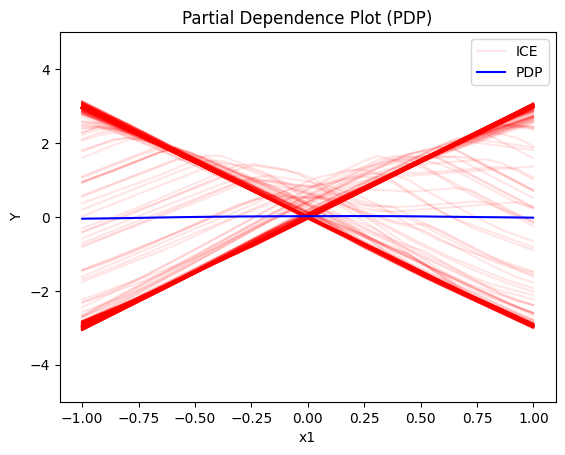

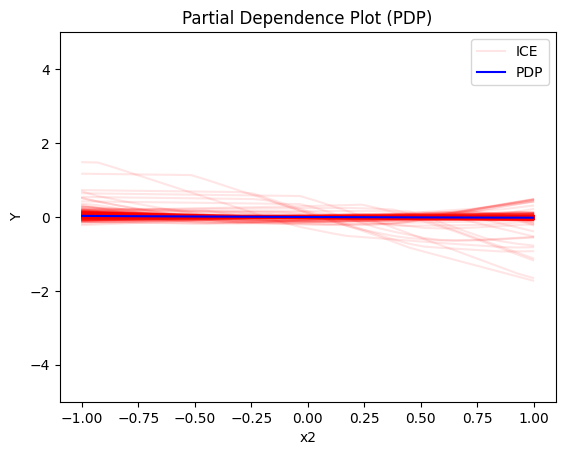

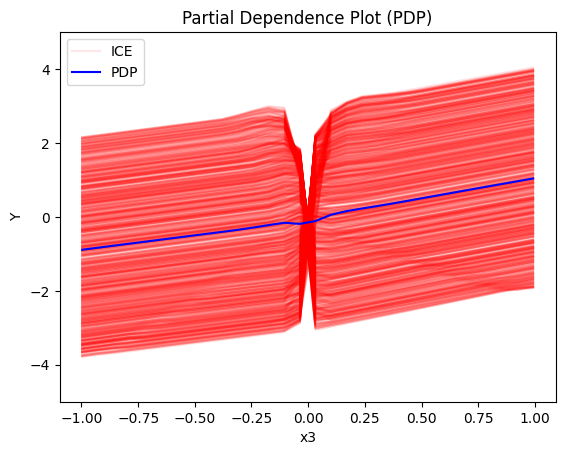

In [6]:
pdp = effector.PDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional PDP

In [7]:
regional_pdp = effector.RegionalPDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
space_partitioner = effector.space_partitioning.Best(min_heterogeneity_decrease_pcg=0.3, numerical_features_grid_size=10)
regional_pdp.fit(features="all", space_partitioner=space_partitioner)

100%|██████████| 3/3 [00:00<00:00, 39.83it/s]


In [8]:
regional_pdp.summary(features=0)



Feature 0 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x1 🔹 [id: 0 | heter: 3.38 | inst: 1000 | w: 1.00]
    x3 ≤ 0.00 🔹 [id: 1 | heter: 0.10 | inst: 500 | w: 0.50]
    x3 > 0.00 🔹 [id: 2 | heter: 0.16 | inst: 500 | w: 0.50]
--------------------------------------------------
Feature 0 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 3.38
    Level 1🔹heter: 0.13 | 🔻3.26 (96.20%)




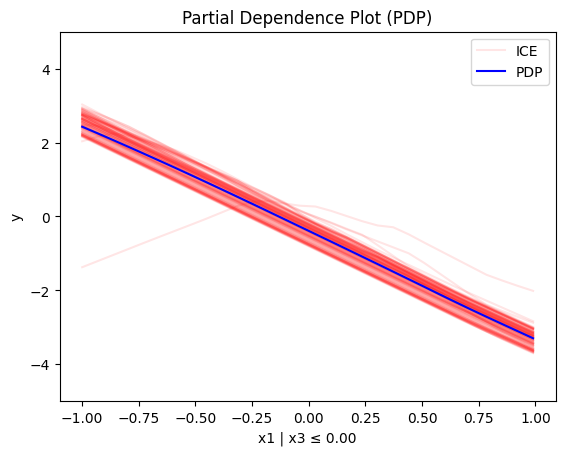

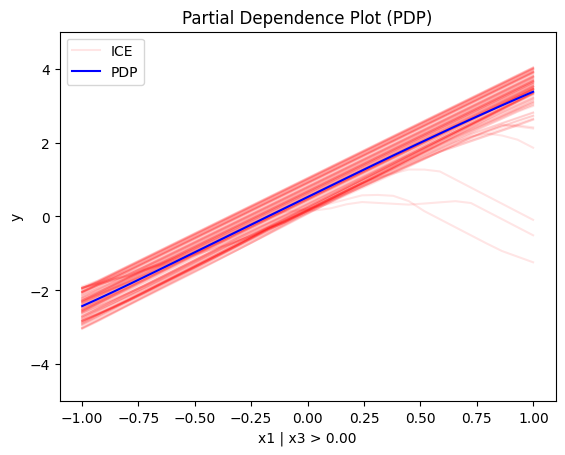

In [9]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", y_limits=[-5, 5])

In [10]:
regional_pdp.summary(features=1)



Feature 1 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x2 🔹 [id: 0 | heter: 3.22 | inst: 1000 | w: 1.00]
--------------------------------------------------
Feature 1 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 3.22




In [11]:
regional_pdp.summary(features=2)



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x3 🔹 [id: 0 | heter: 2.90 | inst: 1000 | w: 1.00]
    x1 ≤ 0.00 🔹 [id: 1 | heter: 0.71 | inst: 494 | w: 0.49]
    x1 > 0.00 🔹 [id: 2 | heter: 0.71 | inst: 506 | w: 0.51]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 2.90
    Level 1🔹heter: 0.71 | 🔻2.19 (75.41%)




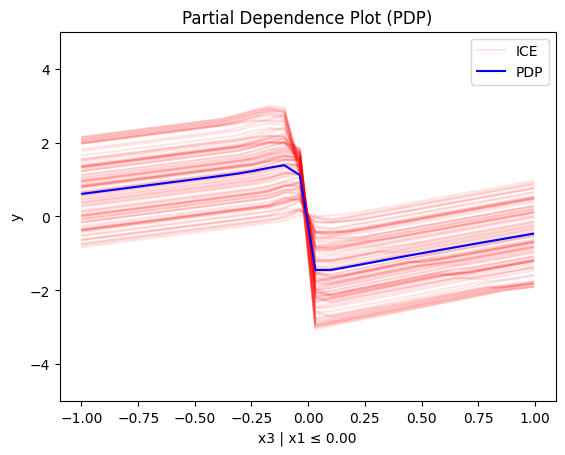

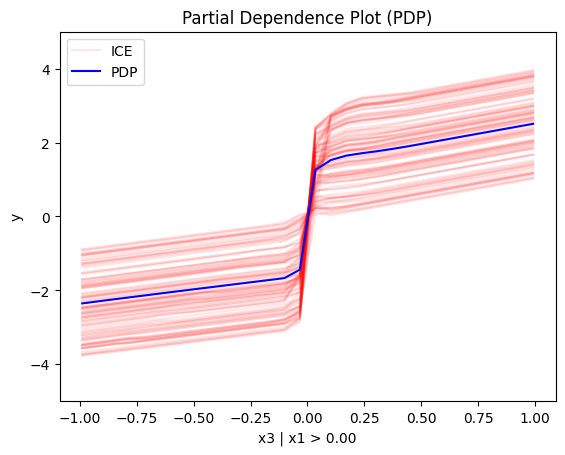

In [12]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

For the Global PDP:

   * the average effect of $x_1$ is $0$ with some heterogeneity implied by the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with a discontinuity around $x_3=0$, with either a positive or a negative offset depending on the value of $x_1^i$

--- 

For the Regional PDP:

* For $x_1$, the algorithm finds two regions, one for $x_3 \leq 0$ and one for $x_3 > 0$
  * when $x_3>0$ the effect is $3x_1$
  * when $x_3 \leq 0$, the effect is $-3x_1$
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ in the first half and $x_3 + 3x_1^i$ later
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ in the first half and $x_3 - 3x_1^i$ later

### Correlated setting


#### Global PDP

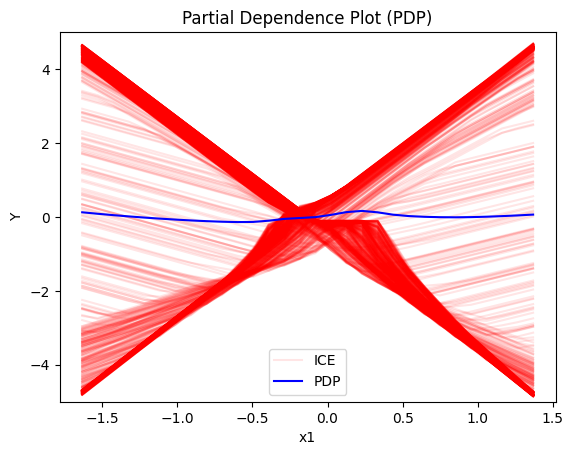

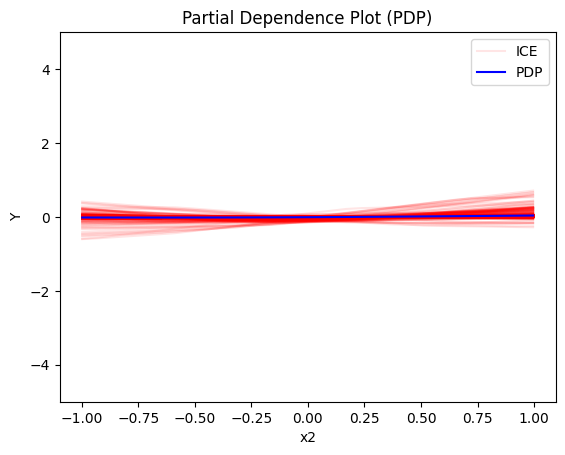

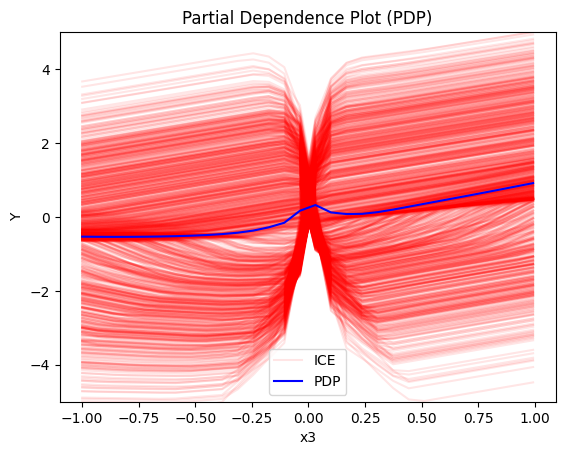

In [13]:
pdp = effector.PDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional-PDP

In [14]:
regional_pdp = effector.RegionalPDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
space_partitioner = effector.space_partitioning.Best(min_heterogeneity_decrease_pcg=0.4, numerical_features_grid_size=10)
regional_pdp.fit(features="all", space_partitioner=space_partitioner)

100%|██████████| 3/3 [00:00<00:00, 54.75it/s]


In [15]:
regional_pdp.summary(features=0)



Feature 0 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x1 🔹 [id: 0 | heter: 3.25 | inst: 900 | w: 1.00]
    x3 ≤ 0.00 🔹 [id: 1 | heter: 0.17 | inst: 436 | w: 0.48]
    x3 > 0.00 🔹 [id: 2 | heter: 0.20 | inst: 464 | w: 0.52]
--------------------------------------------------
Feature 0 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 3.25
    Level 1🔹heter: 0.18 | 🔻3.07 (94.40%)




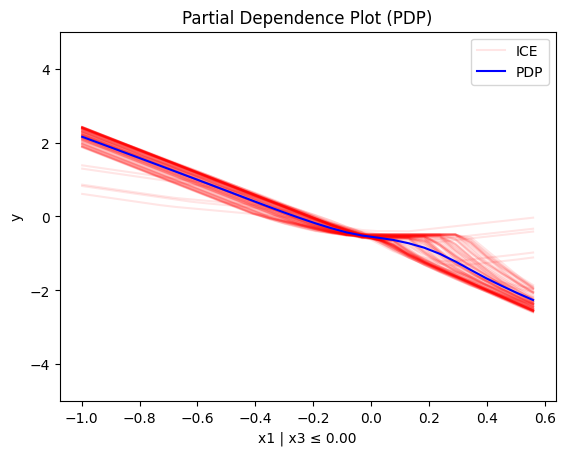

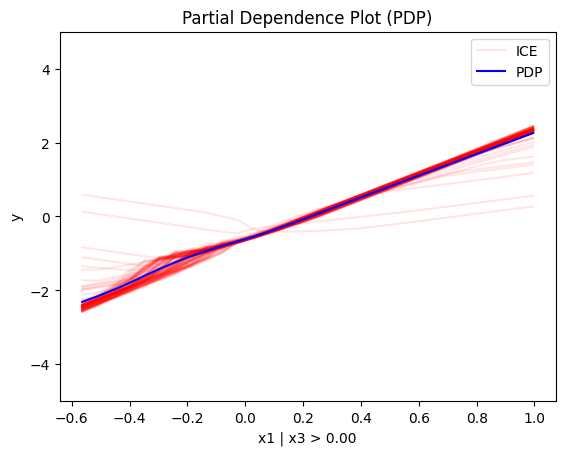

In [16]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

In [17]:
regional_pdp.summary(features=1)



Feature 1 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x2 🔹 [id: 0 | heter: 1.22 | inst: 900 | w: 1.00]
    x1 ≤ 0.40 🔹 [id: 1 | heter: 0.57 | inst: 652 | w: 0.72]
    x1 > 0.40 🔹 [id: 2 | heter: 0.55 | inst: 248 | w: 0.28]
--------------------------------------------------
Feature 1 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 1.22
    Level 1🔹heter: 0.56 | 🔻0.66 (54.17%)




In [18]:
regional_pdp.summary(features=2)



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x3 🔹 [id: 0 | heter: 2.44 | inst: 900 | w: 1.00]
    x1 ≤ 0.00 🔹 [id: 1 | heter: 0.74 | inst: 463 | w: 0.51]
    x1 > 0.00 🔹 [id: 2 | heter: 0.81 | inst: 437 | w: 0.49]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 2.44
    Level 1🔹heter: 0.77 | 🔻1.67 (68.34%)




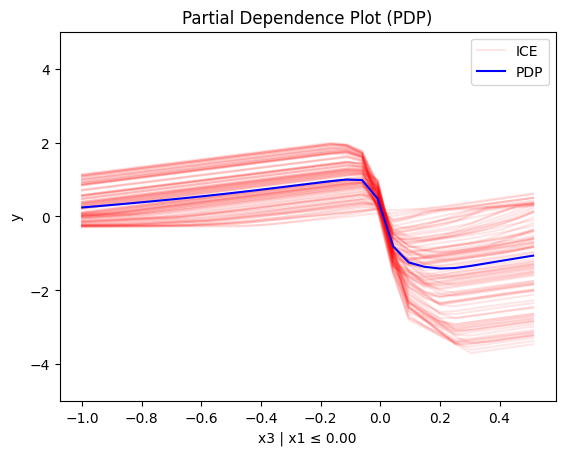

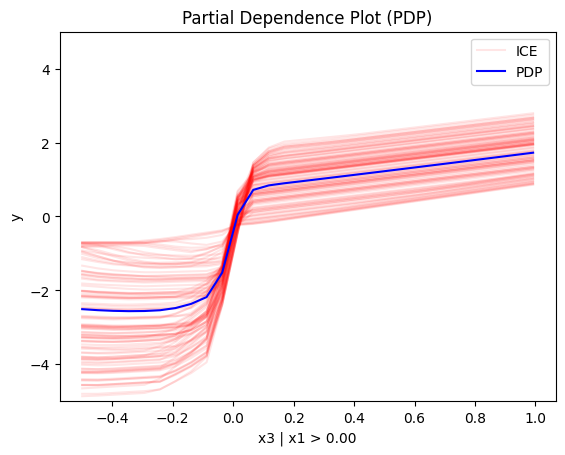

In [19]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

## (RH)ALE

In [20]:
def model_uncor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_uncor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_cor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_cor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

### Uncorrelated setting

#### Global RHALE

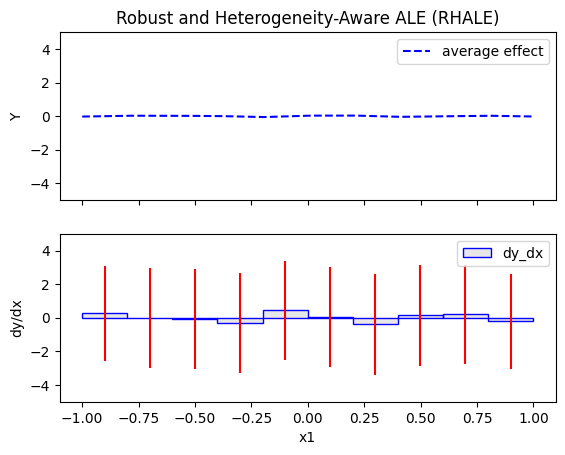

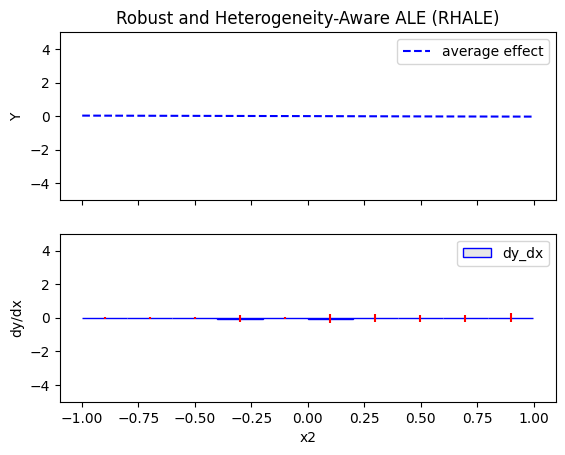

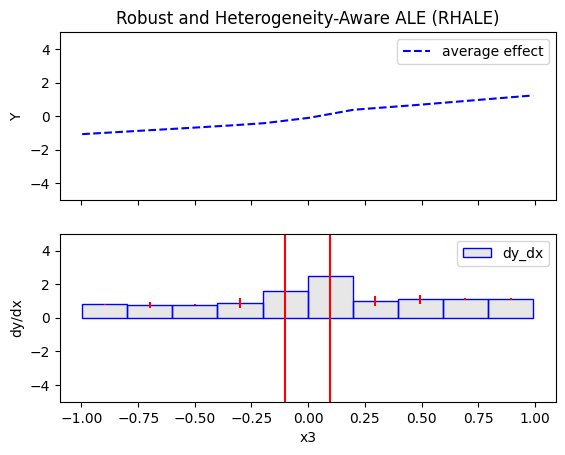

In [21]:
rhale = effector.RHALE(data=X_uncor_train, model=model_uncor, model_jac=model_uncor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.axis_partitioning.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE


In [22]:
regional_rhale = effector.RegionalRHALE(
    data=X_uncor_train, 
    model=model_uncor, 
    model_jac= model_uncor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.axis_partitioning.Fixed(11, min_points_per_bin=0)
space_partitioner = effector.space_partitioning.Best(min_heterogeneity_decrease_pcg=0.6, numerical_features_grid_size=10)
regional_rhale.fit(
    features="all",
    binning_method=binning_method,
    space_partitioner=space_partitioner
)


100%|██████████| 3/3 [00:00<00:00, 17.88it/s]


In [23]:
regional_rhale.summary(features=0)



Feature 0 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x1 🔹 [id: 0 | heter: 8.64 | inst: 1000 | w: 1.00]
    x3 ≤ 0.00 🔹 [id: 1 | heter: 0.26 | inst: 500 | w: 0.50]
    x3 > 0.00 🔹 [id: 2 | heter: 0.47 | inst: 500 | w: 0.50]
--------------------------------------------------
Feature 0 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 8.64
    Level 1🔹heter: 0.37 | 🔻8.28 (95.77%)




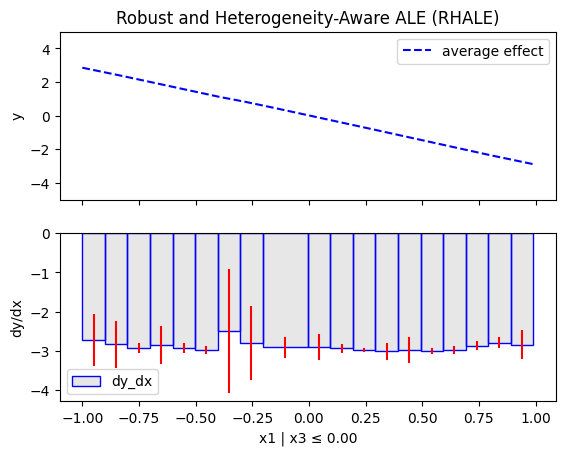

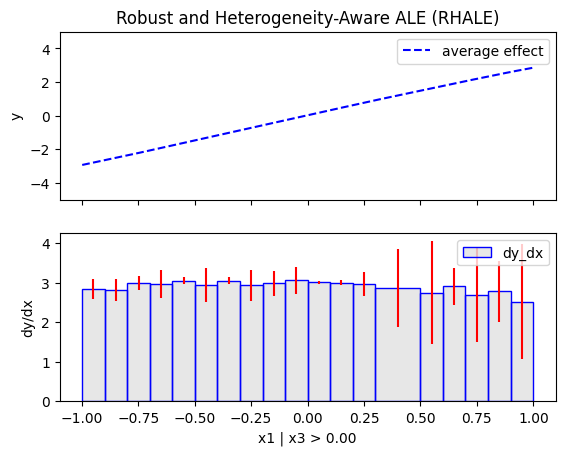

In [24]:
regional_rhale.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_rhale.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [25]:
regional_rhale.summary(features=1)



Feature 1 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x2 🔹 [id: 0 | heter: 0.03 | inst: 1000 | w: 1.00]
--------------------------------------------------
Feature 1 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.03




In [26]:
regional_rhale.summary(features=2)



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x3 🔹 [id: 0 | heter: 73.33 | inst: 1000 | w: 1.00]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 73.33




#### Conclusion

### Correlated setting

#### Global RHALE

In [27]:
rhale = effector.RHALE(data=X_cor_train, model=model_cor, model_jac=model_cor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.axis_partitioning.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

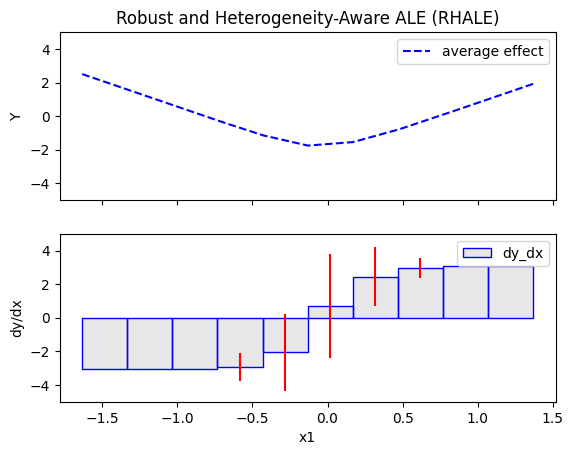

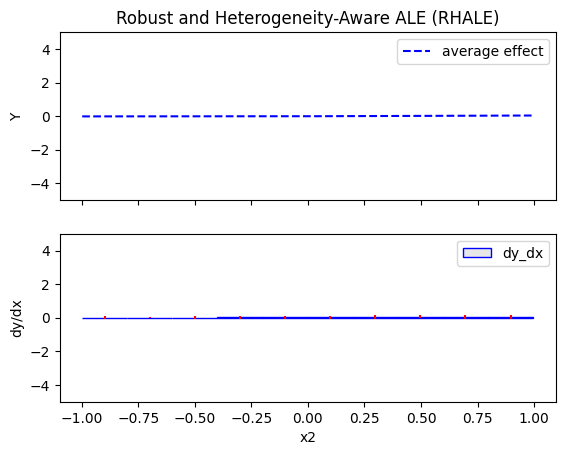

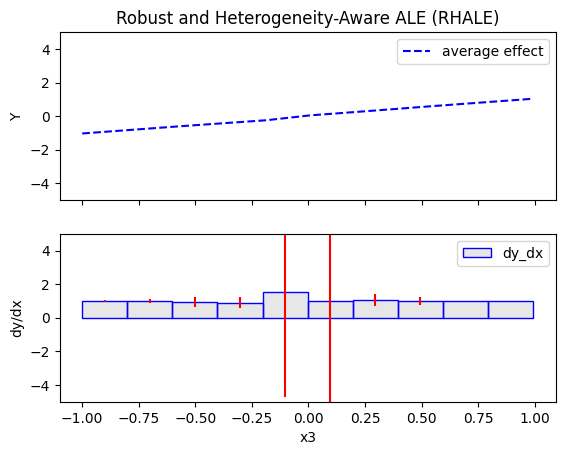

In [28]:
rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE

In [29]:
regional_rhale = effector.RegionalRHALE(
    data=X_cor_train, 
    model=model_cor, 
    model_jac= model_cor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.axis_partitioning.Fixed(11, min_points_per_bin=0)
space_partitioner = effector.space_partitioning.Best(min_heterogeneity_decrease_pcg=0.6, numerical_features_grid_size=10)
regional_rhale.fit(
    features="all",
    space_partitioner=space_partitioner,
)

100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


In [30]:
regional_rhale.summary(features=0)



Feature 0 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x1 🔹 [id: 0 | heter: 2.50 | inst: 900 | w: 1.00]
--------------------------------------------------
Feature 0 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 2.50




In [31]:
regional_rhale.summary(features=1)



Feature 1 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x2 🔹 [id: 0 | heter: 0.01 | inst: 900 | w: 1.00]
--------------------------------------------------
Feature 1 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.01




In [32]:
regional_rhale.summary(features=2)



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x3 🔹 [id: 0 | heter: 13.57 | inst: 900 | w: 1.00]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 13.57




#### Conclusion

## SHAP DP
### Uncorrelated setting
#### Global SHAP DP


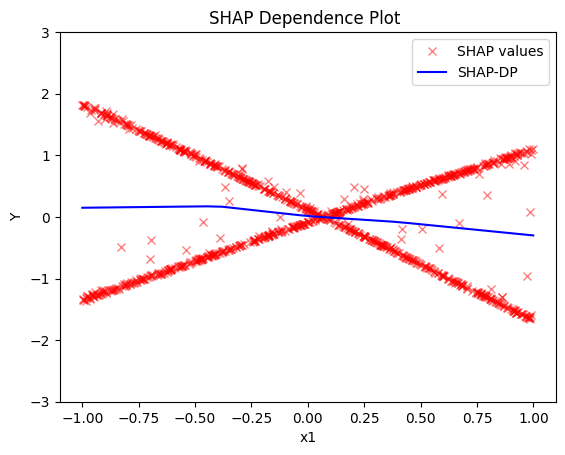

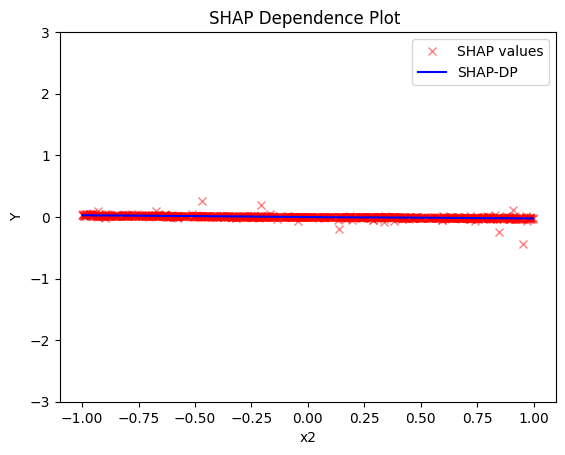

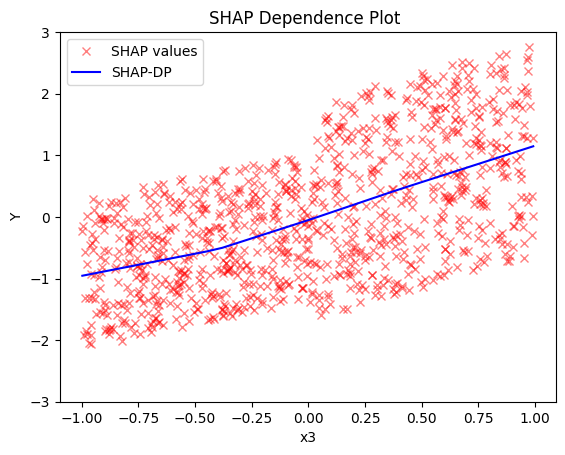

In [33]:
shap = effector.ShapDP(data=X_uncor_train, model=model_uncor, feature_names=['x1', 'x2', 'x3'], target_name="Y")
binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
shap.fit(features="all", binning_method=binning_method, centering=True)
shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])


#### Regional SHAP-DP

In [34]:
regional_shap = effector.RegionalShapDP(
    data=X_uncor_train,
    model=model_uncor,
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

space_partitioner = effector.space_partitioning.Best(min_heterogeneity_decrease_pcg=0.6, numerical_features_grid_size=10)
regional_shap.fit(
    features="all",
    space_partitioner=space_partitioner,
    binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
)


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


In [35]:
regional_shap.summary(0)



Feature 0 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x1 🔹 [id: 0 | heter: 0.83 | inst: 1000 | w: 1.00]
    x3 ≤ 0.00 🔹 [id: 1 | heter: 0.04 | inst: 500 | w: 0.50]
    x3 > 0.00 🔹 [id: 2 | heter: 0.03 | inst: 500 | w: 0.50]
--------------------------------------------------
Feature 0 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.83
    Level 1🔹heter: 0.03 | 🔻0.79 (95.81%)




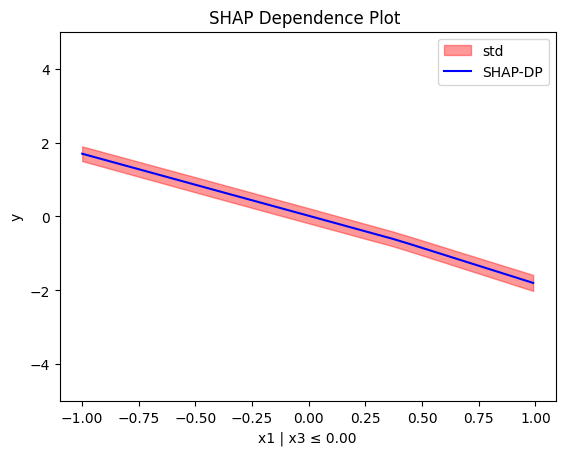

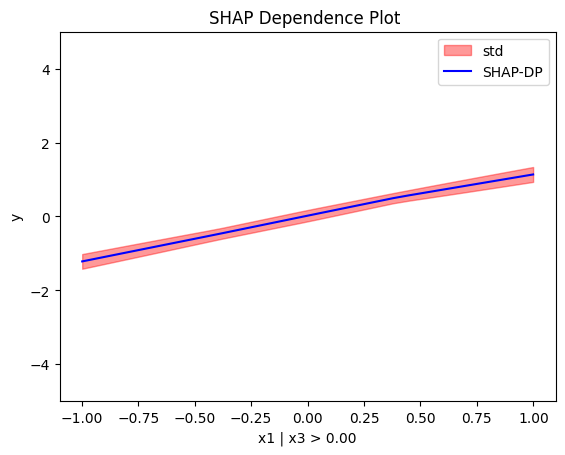

In [36]:
regional_shap.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_shap.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [37]:
regional_shap.summary(features=1)



Feature 1 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x2 🔹 [id: 0 | heter: 0.00 | inst: 1000 | w: 1.00]
--------------------------------------------------
Feature 1 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.00




In [38]:
regional_shap.summary(features=2)



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x3 🔹 [id: 0 | heter: 0.77 | inst: 1000 | w: 1.00]
    x1 ≤ 0.00 🔹 [id: 1 | heter: 0.25 | inst: 494 | w: 0.49]
    x1 > 0.00 🔹 [id: 2 | heter: 0.34 | inst: 506 | w: 0.51]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.77
    Level 1🔹heter: 0.30 | 🔻0.47 (60.94%)




#### Conclusion

### Correlated setting

#### Global SHAP-DP


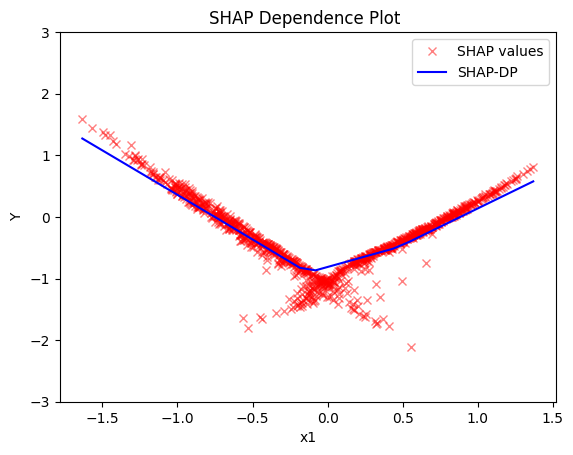

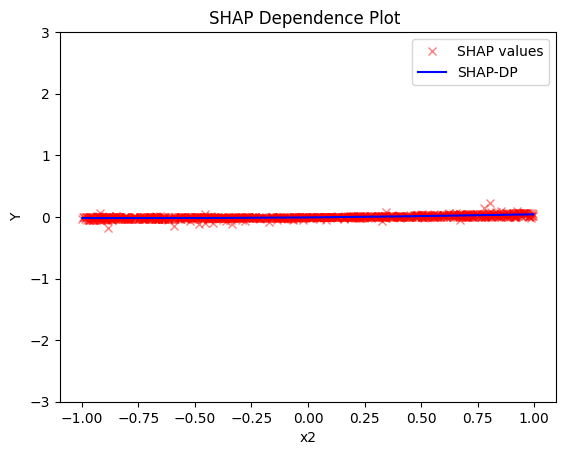

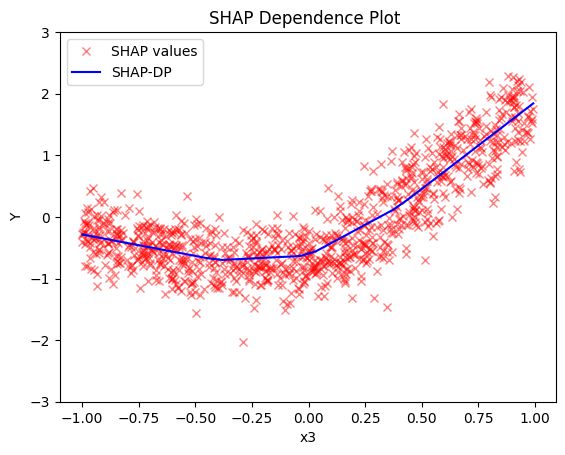

In [39]:

shap = effector.ShapDP(data=X_cor_train, model=model_cor, feature_names=['x1', 'x2', 'x3'], target_name="Y")
binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
shap.fit(features="all", binning_method=binning_method, centering=True)
shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])


#### Regional SHAP

In [40]:
regional_shap = effector.RegionalShapDP(
    data=X_cor_train,
    model=model_cor,
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

space_partitioner = effector.space_partitioning.Best(min_heterogeneity_decrease_pcg=0.6, numerical_features_grid_size=10)
regional_shap.fit(
    features="all",
    space_partitioner=space_partitioner,
    binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
)

100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


In [41]:
regional_shap.summary(0)
regional_shap.summary(1)
regional_shap.summary(2)



Feature 0 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x1 🔹 [id: 0 | heter: 0.06 | inst: 900 | w: 1.00]
--------------------------------------------------
Feature 0 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.06




Feature 1 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x2 🔹 [id: 0 | heter: 0.00 | inst: 900 | w: 1.00]
--------------------------------------------------
Feature 1 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.00




Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
x3 🔹 [id: 0 | heter: 0.14 | inst: 900 | w: 1.00]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.14




#### Conclusion

